In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.integrate import solve_ivp
import pickle
import seaborn as sns
import matplotlib as mpl

In [ ]:
# Parameters
n_steps = 1500
dt = 1
ref_price_a, ref_price_b = 100, 100
lambda_a, lambda_b = 1.0, 1.0
std_price_a, std_price_b = 1.0, 1.0
delta_a, delta_b = dt * 0.01, dt * 0.01
phi_a, phi_b = dt * 20, dt * 20
initial_particles_a = 500
initial_particles_b = 500
n_histograms = 750

# Initialize particles
prices_a = np.random.normal(loc=ref_price_a, scale=std_price_a, size=initial_particles_a)
mask_a = prices_a[:] > ref_price_a + 0.5
prices_a = prices_a[mask_a]
sizes_a = np.random.exponential(scale=1 / lambda_a, size=len(prices_a))
A_initial = prices_a.copy()

prices_b = np.random.normal(loc=ref_price_b, scale=std_price_b, size=initial_particles_b)
mask_b = prices_b[:] < ref_price_b - 0.5
prices_b = prices_b[mask_b]
sizes_b = np.random.exponential(scale=1 / lambda_b, size=len(prices_b))
B_initial = prices_b.copy()

particles_a = np.column_stack((prices_a, sizes_a))
particles_b = np.column_stack((prices_b, sizes_b))

starting_distribution_a = particles_a.copy()
starting_distribution_b = particles_b.copy()

price_bins = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    500
)

hist_a, _ = np.histogram(A_initial, bins=price_bins)
hist_b, _ = np.histogram(B_initial, bins=price_bins)

# Arrays to store statistics
time_steps = []
n_a_array = []
n_b_array = []
mean_price_a_array = []
mean_price_b_array = []
std_price_a_array = []
std_price_b_array = []

# To store histograms of the last 1000 steps
last_histograms_a = []
last_histograms_b = []

# Functions
def add_entries():
    global particles_a, particles_b

    n_new_a = np.random.poisson(phi_a)
    n_new_b = np.random.poisson(phi_b)

    # Generate all new A and B particles
    new_prices_a = np.random.normal(loc=ref_price_a, scale=std_price_a, size=n_new_a)
    new_sizes_a = np.random.exponential(scale=1 / lambda_a, size=n_new_a)
    
    new_prices_b = np.random.normal(loc=ref_price_b, scale=std_price_b, size=n_new_b)
    new_sizes_b = np.random.exponential(scale=1 / lambda_b, size=n_new_b)

    # Create a list of all new particles with their type info
    all_new_particles = []
    
    for p, s in zip(new_prices_a, new_sizes_a):
        all_new_particles.append(('A', p, s))
        
    for p, s in zip(new_prices_b, new_sizes_b):
        all_new_particles.append(('B', p, s))

    # Shuffle to randomize processing order
    np.random.shuffle(all_new_particles)

    # Process each particle in the shuffled list
    for particle in all_new_particles:
        ptype, price, size = particle
        
        if ptype == 'A':
            # Try to insert A particle: must be <= max price in B
            if len(particles_b) == 0:
                # No B particles available to remove; skip adding
                continue
                
            max_price_idx = np.argmax(particles_b[:, 0])
            price_b, size_b = particles_b[max_price_idx]
            
            if price <= price_b:
                particles_b = np.delete(particles_b, max_price_idx, axis=0)
            else:
                particles_a = np.vstack((particles_a, [price, size]))
                
        elif ptype == 'B':
            # Try to insert B particle: must be >= min price in A
            if len(particles_a) == 0:
                # No A particles available to remove; skip adding
                continue
                
            min_price_idx = np.argmin(particles_a[:, 0])
            price_a, size_a = particles_a[min_price_idx]
            
            if price_a <= price:
                particles_a = np.delete(particles_a, min_price_idx, axis=0)
            else:
                particles_b = np.vstack((particles_b, [price, size]))
    
def apply_cancellations():
    global particles_a, particles_b

    particles_a = particles_a[np.random.rand(len(particles_a)) > delta_a]
    particles_b = particles_b[np.random.rand(len(particles_b)) > delta_b]

def record_statistics(step):
    global time_steps, n_a_array, n_b_array, mean_price_a_array, mean_price_b_array, std_price_a_array, std_price_b_array, particles_a, particles_b

    time_steps.append(step)
    n_a_array.append(len(particles_a))
    n_b_array.append(len(particles_b))

def record_histograms(n_histograms = n_histograms):
    global last_histograms_a, last_histograms_b
    
    hist_a, _ = np.histogram(particles_a[:, 0], bins=price_bins)
    hist_b, _ = np.histogram(particles_b[:, 0], bins=price_bins)
    
    last_histograms_a.append(hist_a)
    last_histograms_b.append(hist_b)

    if len(last_histograms_a) > n_histograms:
        last_histograms_a.pop(0)
    if len(last_histograms_b) > n_histograms:
        last_histograms_b.pop(0)

def one_step(step):
    record_statistics(step)
    add_entries()
    apply_cancellations()
    if step >= n_steps - n_histograms:
        record_histograms()

# Run simulation
for step in range(n_steps):
    one_step(step)
    if len(particles_a) == 0 and len(particles_b) == 0:
        print(f"Simulation ended at step {step}.")
        break

# Average histograms
dp = price_bins[1]-price_bins[0]
final_counts_a = np.mean(last_histograms_a/dp, axis=0)
final_counts_b = np.mean(last_histograms_b/dp, axis=0)

initial_counts_a, _ = np.histogram(starting_distribution_a[:, 0], bins=price_bins)
initial_counts_b, _ = np.histogram(starting_distribution_b[:, 0], bins=price_bins)
xvalues = [(price_bins[i] + price_bins[i+1])/2 for i in range(len(price_bins) -1 )]

dp_sim = dp

In [ ]:
with open("resources\\Simulacion LOB\\totales_n_a_5.pkl", 'wb') as f:
    pickle.dump(n_a_array,f)
with open("resources\\Simulacion LOB\\totales_n_b_5.pkl", 'wb') as f:
    pickle.dump(n_b_array,f)
with open("resources\\Simulacion LOB\\times_5.pkl", 'wb') as f:
    pickle.dump(time_steps,f)
with open("resources\\Simulacion LOB\\n_A_estacionario_5.pkl", 'wb') as f:
    pickle.dump(final_counts_a,f)
with open("resources\\Simulacion LOB\\n_B_estacionario_5.pkl", 'wb') as f:
    pickle.dump(final_counts_b,f)

In [3]:
with open("resources\\Simulacion LOB\\n_A_estacionario_1.pkl", 'rb') as f:
    n_a_est_sim_1 = pickle.load(f)
with open("resources\\Simulacion LOB\\n_B_estacionario_1.pkl", 'rb') as f:
    n_b_est_sim_1 = pickle.load(f)

with open("resources\\Simulacion LOB\\totales_n_a_1.pkl", 'rb') as f:
    n_a_sim_1 = pickle.load(f)
with open("resources\\Simulacion LOB\\totales_n_b_1.pkl", 'rb') as f:
    n_b_sim_1 = pickle.load(f)
with open("resources\\Simulacion LOB\\times_1.pkl", 'rb') as f:
    times_sim = pickle.load(f)

with open("resources\\Simulacion LOB\\n_A_estacionario_2.pkl", 'rb') as f:
    n_a_est_sim_2 = pickle.load(f)
with open("resources\\Simulacion LOB\\n_B_estacionario_2.pkl", 'rb') as f:
    n_b_est_sim_2 = pickle.load(f)

with open("resources\\Simulacion LOB\\totales_n_a_2.pkl", 'rb') as f:
    n_a_sim_2 = pickle.load(f)
with open("resources\\Simulacion LOB\\totales_n_b_2.pkl", 'rb') as f:
    n_b_sim_2 = pickle.load(f)

with open("resources\\Simulacion LOB\\n_A_estacionario_3.pkl", 'rb') as f:
    n_a_est_sim_3 = pickle.load(f)
with open("resources\\Simulacion LOB\\n_B_estacionario_3.pkl", 'rb') as f:
    n_b_est_sim_3 = pickle.load(f)

with open("resources\\Simulacion LOB\\totales_n_a_3.pkl", 'rb') as f:
    n_a_sim_3 = pickle.load(f)
with open("resources\\Simulacion LOB\\totales_n_b_3.pkl", 'rb') as f:
    n_b_sim_3 = pickle.load(f)

with open("resources\\Simulacion LOB\\n_A_estacionario_4.pkl", 'rb') as f:
    n_a_est_sim_4 = pickle.load(f)
with open("resources\\Simulacion LOB\\n_B_estacionario_4.pkl", 'rb') as f:
    n_b_est_sim_4 = pickle.load(f)

with open("resources\\Simulacion LOB\\totales_n_a_4.pkl", 'rb') as f:
    n_a_sim_4 = pickle.load(f)
with open("resources\\Simulacion LOB\\totales_n_b_4.pkl", 'rb') as f:
    n_b_sim_4 = pickle.load(f)

with open("resources\\Simulacion LOB\\n_A_estacionario_5.pkl", 'rb') as f:
    n_a_est_sim_5 = pickle.load(f)
with open("resources\\Simulacion LOB\\n_B_estacionario_5.pkl", 'rb') as f:
    n_b_est_sim_5 = pickle.load(f)

with open("resources\\Simulacion LOB\\totales_n_a_5.pkl", 'rb') as f:
    n_a_sim_5 = pickle.load(f)
with open("resources\\Simulacion LOB\\totales_n_b_5.pkl", 'rb') as f:
    n_b_sim_5 = pickle.load(f)
    
n_a_sim = np.mean(np.array([n_a_sim_1, n_a_sim_2, n_a_sim_3, n_a_sim_4, n_a_sim_5]),axis=0)
n_b_sim = np.mean(np.array([n_b_sim_1,n_b_sim_2, n_b_sim_3, n_b_sim_4, n_b_sim_5]), axis=0)
n_a_est_sim = np.mean(np.array([n_a_est_sim_1,n_a_est_sim_2,n_a_est_sim_3,n_a_est_sim_4,n_a_est_sim_5]), axis=0)
n_b_est_sim = np.mean(np.array([n_b_est_sim_1,n_b_est_sim_2,n_b_est_sim_3, n_b_est_sim_4, n_b_est_sim_5]), axis=0)

In [4]:
num_sims = 5

std_n_a_sim = np.std(n_a_sim, axis=0) / np.sqrt(num_sims)

upper_bound_n_a_sim = n_a_sim + std_n_a_sim
lower_bound_n_a_sim = n_a_sim - std_n_a_sim

std_n_b_sim = np.std(n_b_sim, axis=0) / np.sqrt(num_sims)

upper_bound_n_b_sim = n_b_sim + std_n_b_sim
lower_bound_n_b_sim = n_b_sim - std_n_b_sim

Iteración 1, ΔN_a: 4.96e+02, ΔN_b: 4.96e+02, Δa: 1.99e+02, Δb: 1.99e+02
Iteración 2, ΔN_a: 5.99e+00, ΔN_b: 5.99e+00, Δa: 2.40e+00, Δb: 2.40e+00
Iteración 3, ΔN_a: 6.34e+01, ΔN_b: 6.34e+01, Δa: 6.17e+01, Δb: 6.17e+01
Iteración 4, ΔN_a: 1.69e+02, ΔN_b: 1.69e+02, Δa: 2.81e+02, Δb: 2.81e+02
Iteración 5, ΔN_a: 9.97e+01, ΔN_b: 9.97e+01, Δa: 3.87e+02, Δb: 3.87e+02
Iteración 6, ΔN_a: 4.70e+01, ΔN_b: 4.70e+01, Δa: 2.81e+02, Δb: 2.81e+02
Iteración 7, ΔN_a: 3.55e+01, ΔN_b: 3.55e+01, Δa: 3.39e+02, Δb: 3.39e+02
Iteración 8, ΔN_a: 2.92e+00, ΔN_b: 2.92e+00, Δa: 2.85e+01, Δb: 2.85e+01
Iteración 9, ΔN_a: 1.40e+01, ΔN_b: 1.40e+01, Δa: 1.38e+02, Δb: 1.38e+02
Iteración 10, ΔN_a: 4.03e+01, ΔN_b: 4.03e+01, Δa: 3.99e+02, Δb: 3.99e+02
Iteración 11, ΔN_a: 1.05e-01, ΔN_b: 1.05e-01, Δa: 1.01e+00, Δb: 1.01e+00
Iteración 12, ΔN_a: 1.39e-03, ΔN_b: 1.39e-03, Δa: 1.30e-02, Δb: 1.30e-02
Iteración 13, ΔN_a: 6.41e-04, ΔN_b: 6.41e-04, Δa: 6.10e-03, Δb: 6.10e-03
Iteración 14, ΔN_a: 2.87e-04, ΔN_b: 2.87e-04, Δa: 2.77e-03, 

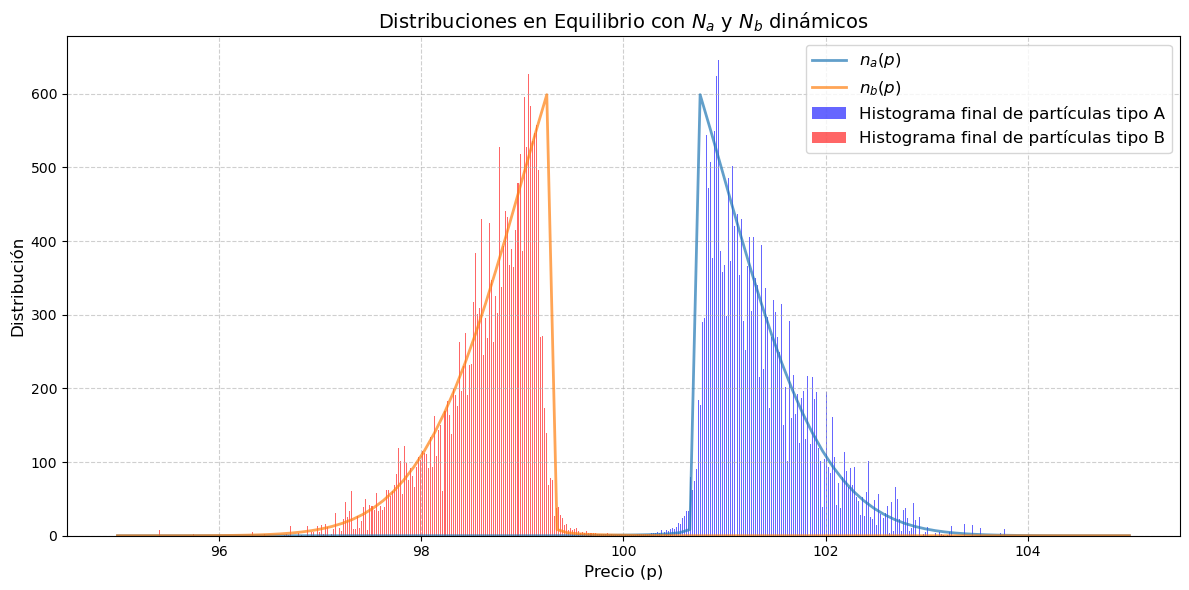

In [ ]:
################################################# 
# Fixed Point Integration
#################################################

# Parameters
phi_a = 20
phi_b = 20
Delta_a = 0.01
Delta_b = 0.01
sigma_a = 1
sigma_b = 1

# Defining reference prices and standard deviations
ref_price_a = 100
ref_price_b = 100
std_price_a = 1
std_price_b = 1

# Creating price grids
p_min = min(ref_price_a, ref_price_b) - 5 * std_price_b
p_max = max(ref_price_a, ref_price_b) + 5 * std_price_a
p_grid = np.linspace(p_min, p_max, 100) 
step = p_grid[1] - p_grid[0]

def gaussian(p, mu, sigma):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp( - (p - mu)**2 / (2*sigma**2) )

# Initializations
N_a_initial = 500.0
N_b_initial = 500.0

N_a = 500.0
N_b = 500.0

P_a = gaussian(p_grid, ref_price_a, sigma_a)
P_b = gaussian(p_grid, ref_price_b, sigma_b)

n_a = N_a * P_a
n_b = N_b * P_b

n_a_initial = n_a.copy()
n_b_initial = n_b.copy()

tolerance = 1e-6
max_iterations = 50
converged = False
iteration = 0

epsilon = 1e-10  

cdf_a_array = []
cdf_b_array = []
integral_P_a = []
integral_P_b = []

while not converged and iteration < max_iterations:
    iteration += 1

    cum_n_b = integrate.cumulative_trapezoid(n_b, x=p_grid, initial=0)
    cum_n_a = integrate.cumulative_trapezoid(n_a, x=p_grid, initial=0)
    
    cum_phi_b_Pb = integrate.cumulative_trapezoid(phi_b * P_b, x=p_grid, initial=0)
    cum_phi_a_Pa = integrate.cumulative_trapezoid(phi_a * P_a, x=p_grid, initial=0)

    new_n_a = np.zeros_like(n_a)
    new_n_b = np.zeros_like(n_b)

    for i in range(len(p_grid)):
        
        CDF_b_p = np.clip(cum_n_b[i] / N_b, epsilon, 1 - epsilon)
        CDF_a_tail_p = np.clip((cum_n_a[-1] - cum_n_a[i]) / N_a, epsilon, 1 - epsilon)

        term1_n_a = phi_a * P_a[i] * (CDF_b_p)**N_b
        integral_p_to_end_phi_b_Pb = cum_phi_b_Pb[-1] - cum_phi_b_Pb[i]
        term_denominator_n_a = integral_p_to_end_phi_b_Pb * (CDF_a_tail_p)**(N_a - 1)
        denominator_n_a = Delta_a + term_denominator_n_a

        new_n_a[i] = term1_n_a / denominator_n_a

        term1_n_b = phi_b * P_b[i] * (CDF_a_tail_p)**N_a
        integral_0_to_p_phi_a_Pa = cum_phi_a_Pa[i]
        term_denominator_n_b = integral_0_to_p_phi_a_Pa * (CDF_b_p)**(N_b - 1)
        denominator_n_b = Delta_b + term_denominator_n_b

        new_n_b[i] = term1_n_b / denominator_n_b

        if iteration == 24:
            cdf_a_array.append(CDF_a_tail_p)
            cdf_b_array.append(CDF_b_p)
            integral_P_a.append(integral_0_to_p_phi_a_Pa)
            integral_P_b.append(integral_p_to_end_phi_b_Pb)

    new_n_a = np.maximum(new_n_a, 0)
    new_n_b = np.maximum(new_n_b, 0)

    cum_new_n_a = integrate.cumulative_trapezoid(new_n_a, x=p_grid, initial=0)
    cum_new_n_b = integrate.cumulative_trapezoid(new_n_b, x=p_grid, initial=0)
    
    new_N_a = cum_new_n_a[-1]
    new_N_b = cum_new_n_b[-1]

    delta_N_a = abs(new_N_a - N_a)
    delta_N_b = abs(new_N_b - N_b)
    delta_a = np.max(np.abs(new_n_a - n_a))
    delta_b = np.max(np.abs(new_n_b - n_b))

    if (delta_N_a < tolerance and delta_N_b < tolerance and 
        delta_a < tolerance and delta_b < tolerance):

        converged = True
    else:
        N_a = new_N_a
        N_b = new_N_b
        n_a = new_n_a.copy()
        n_b = new_n_b.copy()

    if iteration == 24:
        termino_fuente_a = phi_a * P_a * (cdf_b_array)**N_b
        termino_fuente_b = phi_b * P_b * (cdf_a_array)**N_a
        termino_interaccion_a = new_n_a * integral_P_b * (cdf_a_array)**(N_a - 1)
        termino_interaccion_b = new_n_b * integral_P_a * (cdf_b_array)**(N_b - 1)
        state_punto_fijo = np.concatenate((new_n_a, new_n_b))

print("¡Converged!" if converged else "Did not converge")

# Final plot
plt.figure(figsize=(12, 6))
plt.plot(p_grid, n_a, label=r'$n_a(p)$', alpha=0.7, linewidth=2)
plt.plot(p_grid, n_b, label=r'$n_b(p)$', alpha=0.7, linewidth=2)
plt.bar(xvalues, final_counts_a,
        width=0.01, align="center", alpha=0.6, label='Histograma final de partículas tipo A', color="blue", linewidth=2, linestyle="-")
plt.bar(xvalues, final_counts_b, 
        width=0.01, align="center", alpha=0.6, label='Histograma final de partículas tipo B', color="red", linewidth=2, linestyle="-")
plt.xlabel('Precio (p)', fontsize=12)
plt.ylabel('Distribución', fontsize=12)
plt.title('Distribuciones en Equilibrio con $N_a$ y $N_b$ dinámicos', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
################################################# 
# Dynamic Integration
#################################################

# Price grid
ref_price_a = ref_price_b = 100
std_price_a = std_price_b = 1

price_bins = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    1000
)

# Midpoints and bin width
midpoints = (price_bins[:-1] + price_bins[1:]) / 2
dp = price_bins[1] - price_bins[0]
N = len(midpoints)  # Number of bins

# Parameters
phi_a = phi_b = 20
Delta_a = Delta_b = 0.01
mu_a = mu_b = 100
sigma_a = sigma_b = 1

P_a = gaussian(midpoints, ref_price_a, sigma_a)
P_b = gaussian(midpoints, ref_price_b, sigma_b)

# Precompute source terms
source_term_a_new = phi_a * P_a
source_term_b_new = phi_b * P_b

# Precompute integrals
cum_phi_b_Pb = integrate.cumulative_trapezoid(phi_b * P_b, x=midpoints, initial=0)
cum_phi_a_Pa = integrate.cumulative_trapezoid(phi_a * P_a, x=midpoints, initial=0)

integral_p_to_end_phi_b_Pb = cum_phi_b_Pb[-1] - cum_phi_b_Pb
integral_0_to_p_phi_a_Pa = cum_phi_a_Pa

epsilon = 1e-7

# Initial conditions
hist_a, _ = np.histogram(A_initial, bins=price_bins)
hist_b, _ = np.histogram(B_initial, bins=price_bins)

hist_a = np.array(hist_a,dtype=np.float64) / dp
hist_b = np.array(hist_b,dtype=np.float64) / dp

hist_a += epsilon
hist_b += epsilon

state0 = np.concatenate((hist_a, hist_b))

def derivs(t, state):
    n_a = state[:N]
    n_b = state[N:]

    N_a = np.sum(n_a) * dp
    N_b = np.sum(n_b) * dp
    
    N_a = max(N_a, 1e-7)
    N_b = max(N_b, 1e-7)
    
    # Cumulative sums for integrals
    cumsum_b_forward = integrate.cumulative_trapezoid(n_b, x=midpoints, initial=0)
    reverse_cumsum_a = integrate.cumulative_trapezoid(n_a, x=midpoints, initial=0)

    CDF_b_p = np.clip(cumsum_b_forward / N_b, epsilon, 1 - epsilon)
    CDF_a_tail_p = np.clip((reverse_cumsum_a[-1] - reverse_cumsum_a) / N_a, epsilon, 1 - epsilon)
    
    # Compute terms for dna_dt
    power_a_source = CDF_b_p ** N_b
    source_term_a = source_term_a_new * power_a_source
    
    power_a_third = CDF_a_tail_p ** (N_a - 1)
    interaction_term_a = n_a * power_a_third * integral_p_to_end_phi_b_Pb
    
    decay_term_a = Delta_a * n_a
    
    dna_dt = source_term_a - decay_term_a - interaction_term_a
    
    # Compute terms for dnb_dt
    power_b_source = CDF_a_tail_p ** N_a
    source_term_b = source_term_b_new * power_b_source
    
    power_b_third = CDF_b_p  ** (N_b - 1)
    interaction_term_b = n_b * power_b_third * integral_0_to_p_phi_a_Pa
    
    decay_term_b = Delta_b * n_b
    
    dnb_dt = source_term_b - decay_term_b - interaction_term_b
    
    return np.concatenate((dna_dt, dnb_dt))

# Time parameters
T = 1500.0
dt = 0.1
t_eval = np.arange(0, T + dt, dt)

# Solve the ODE system
sol = solve_ivp(derivs, (0, T), state0, t_eval=t_eval, method='RK45')

# Extract and compute total N_a and N_b over time
N_a_total = np.sum(sol.y[:N, :], axis=0) * dp
N_b_total = np.sum(sol.y[N:, :], axis=0) * dp

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


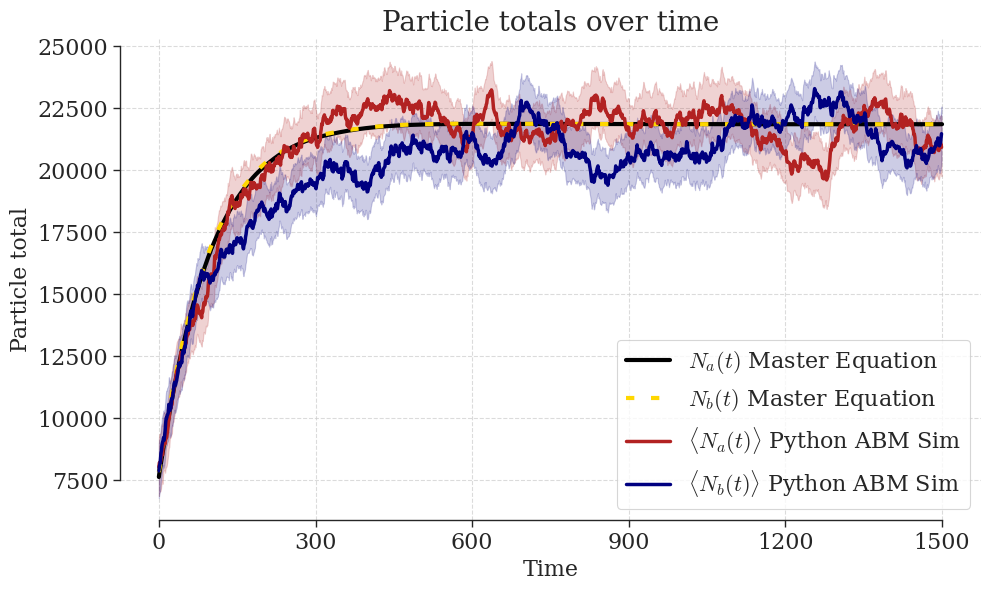

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


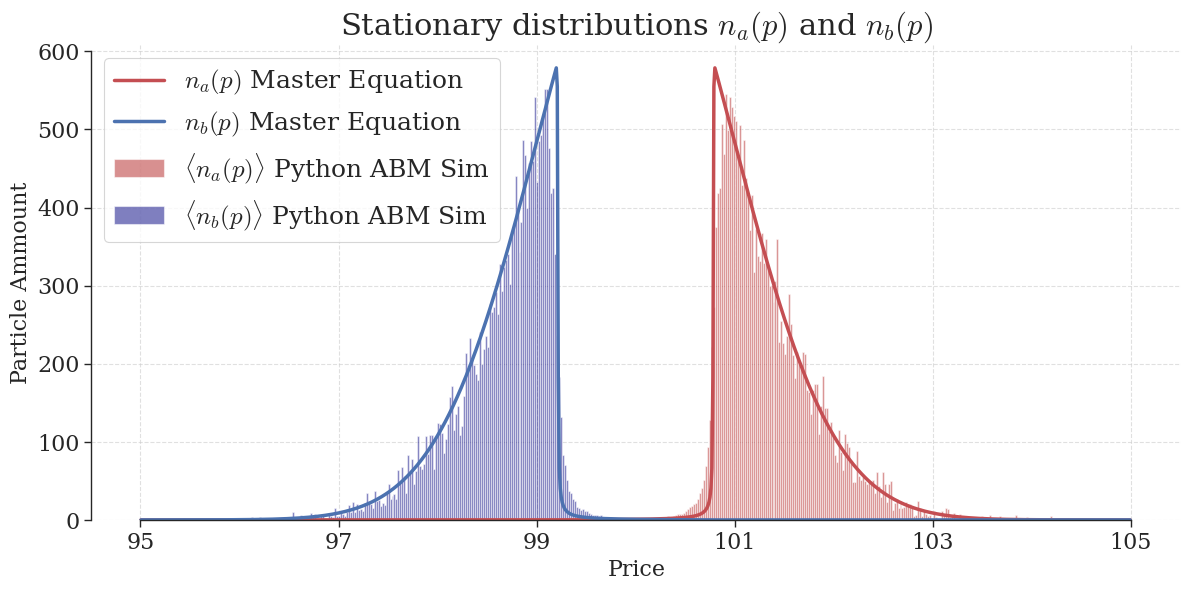

In [ ]:
# Plotting particle totals

# Set global plot style
sns.set(style="ticks", context="paper")
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text

# Time evolution of particle totals
plt.figure(figsize=(10, 6))

# Master equation results
plt.plot(sol.t, N_a_total / dp_sim, label=r'$N_a(t)$ Master Equation', alpha=1, color = 'black', linestyle='-', linewidth=3)
plt.plot(sol.t, N_b_total / dp_sim, label=r'$N_b(t)$ Master Equation', alpha=1, color='gold', linestyle=(0, (2, 4)), linewidth=3)

# Simulation results
plt.plot(times_sim, n_a_sim / dp_sim, label=r'$\langle N_a(t) \rangle$ Python ABM Sim',alpha=1, color='firebrick', linewidth=2.5)
plt.fill_between(times_sim, lower_bound_n_a_sim / dp_sim, upper_bound_n_a_sim / dp_sim,
                 color='firebrick', alpha=0.2)

plt.plot(times_sim, n_b_sim / dp_sim, label=r'$\langle N_b(t) \rangle$ Python ABM Sim',alpha=1, color='navy', linewidth=2.5)
plt.fill_between(times_sim, lower_bound_n_b_sim / dp_sim, upper_bound_n_b_sim / dp_sim,
                 color='navy', alpha=0.2)

plt.title('Particle totals over time', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.xticks(np.arange(0, 1501, step=300))
plt.ylabel('Particle total', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', frameon=True, shadow=False, fancybox=True)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Order Book/Sim vs Int LOB dinamicas.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()


# Stationary distributions
n_a_last = sol.y[:N, -1:].flatten()
n_b_last = sol.y[N:, -1:].flatten()

plt.figure(figsize=(12, 6))

# Master equation solutions
plt.plot(midpoints, n_a_last, label=r'$n_a(p)$ Master Equation', color=sns.color_palette()[3], linestyle='-', linewidth=2.5)
plt.plot(midpoints, n_b_last, label=r'$n_b(p)$ Master Equation', color=sns.color_palette()[0], linestyle='-', linewidth=2.5)

# Simulation histograms
bar_width = dp_sim * 1
plt.bar(xvalues, n_a_est_sim, width=bar_width, align='edge', alpha=0.5,
        label=r'$\langle n_a(p) \rangle$ Python ABM Sim', color='firebrick')
plt.bar(xvalues, n_b_est_sim, width=bar_width, align='edge', alpha=0.5,
        label=r'$\langle n_b(p) \rangle$ Python ABM Sim', color='navy')

plt.xlabel('Price', fontsize=16)
plt.xticks(np.arange(95, 106, step=2))
plt.ylabel('Particle Ammount', fontsize=16)
plt.title(r'Stationary distributions $n_a(p)$ and $n_b(p)$', fontsize=22)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, fancybox=True, fontsize=18)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Order Book/Sim vs Int LOB estacionarias.pdf", format='pdf', dpi=300, bbox_inches='tight',transparent=False, pad_inches=0.1)
plt.show()

In [ ]:
# Loading data from the generalized model simulations 

with open("resources\\Gillespie with beta\\n_A_totales_gillespie.pkl", 'rb') as f:
    n_a_gillespie = pickle.load(f)
with open("resources\\Gillespie with beta\\n_B_totales_gillespie.pkl", 'rb') as f:
    n_b_gillespie = pickle.load(f)
with open("resources\\Gillespie with beta\\times_gillespie.pkl", 'rb') as f:
    times = pickle.load(f)
with open("resources\\Gillespie with beta\\n_A_estacionario_gillespie.pkl", 'rb') as f:
    n_A_estacionario = pickle.load(f)
with open("resources\\Gillespie with beta\\n_B_estacionario_gillespie.pkl", 'rb') as f:
    n_B_estacionario = pickle.load(f)

In [9]:
with open("resources\\Simulacion LOB\\dist_eq_n_a_integral_con_beta.pkl", 'rb') as f:
    n_a_est_integral_con_beta = pickle.load(f)
with open("resources\\Simulacion LOB\\dist_eq_n_b_integral_con_beta.pkl", 'rb') as f:
    n_b_est_integral_con_beta = pickle.load(f)

with open("resources\\Simulacion LOB\\N_a_integral_con_beta.pkl", 'rb') as f:
    N_a_integral_con_beta= pickle.load(f)
with open("resources\\Simulacion LOB\\N_b_integral_con_beta.pkl", 'rb') as f:
    N_b_integral_con_beta = pickle.load(f)

with open("resources\\Simulacion LOB\\times_integral_con_beta.pkl", 'rb') as f:
    times_integral_con_beta = pickle.load(f)

ref_price_a = ref_price_b = 100
std_price_a = std_price_b = 1

price_bins_int_con_beta = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    500
)

# Midpoints of bins and bin width
midpoints_int_con_beta = (price_bins_int_con_beta[:-1] + price_bins_int_con_beta[1:]) / 2
dp_int_con_beta = midpoints_int_con_beta[1] - midpoints_int_con_beta[0]

In [10]:
num_sims_gillespie = 5

std_mean_series_gillespie_a = np.std(n_a_gillespie, axis=0) / np.sqrt(num_sims_gillespie)

upper_bound_mean_series_gillespie_a = n_a_gillespie + std_mean_series_gillespie_a
lower_bound_mean_series_gillespie_a = n_a_gillespie - std_mean_series_gillespie_a

std_mean_series_gillespie_b = np.std(n_b_gillespie, axis=0) / np.sqrt(num_sims_gillespie)

upper_bound_mean_series_gillespie_b = n_b_gillespie + std_mean_series_gillespie_b
lower_bound_mean_series_gillespie_b = n_b_gillespie - std_mean_series_gillespie_b

In [ ]:
mu = 100
ref_price_a = ref_price_b = 100
std_price_a = std_price_b = 1

price_bins_gillespie = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    100
)

price_bins_ec_maest = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    1000
)

# Midpoints of bins and bin width
midpoints_ec_maest = (price_bins_ec_maest[:-1] + price_bins_ec_maest[1:]) / 2
dp_ec_maest = price_bins_ec_maest[1] - price_bins_ec_maest[0]

# Midpoints of bins and bin width
midpoints_gillespie = (price_bins_gillespie[:-1] + price_bins_gillespie[1:]) / 2
dp_gillespie = price_bins_gillespie[1] - price_bins_gillespie[0]

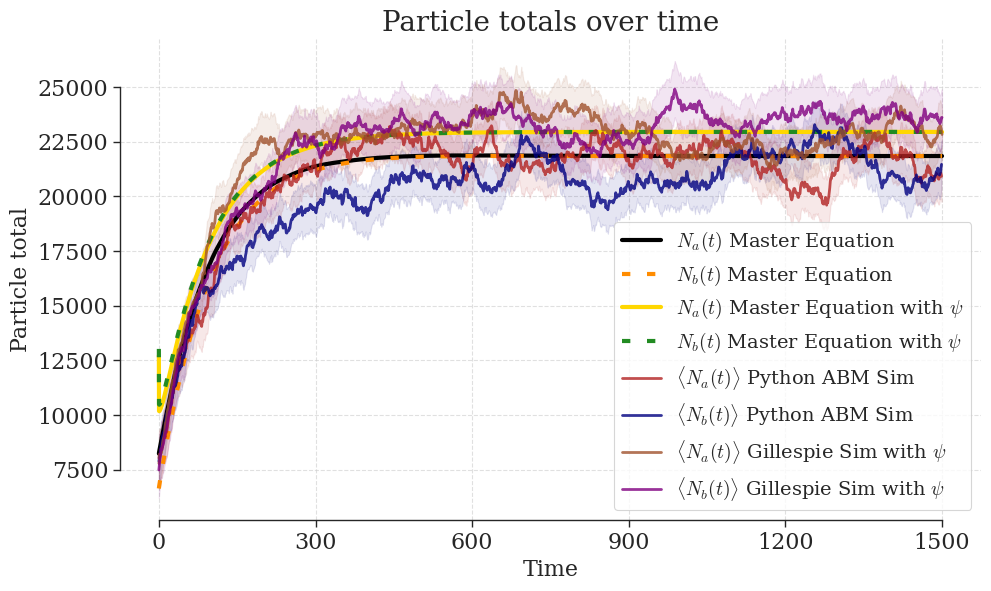

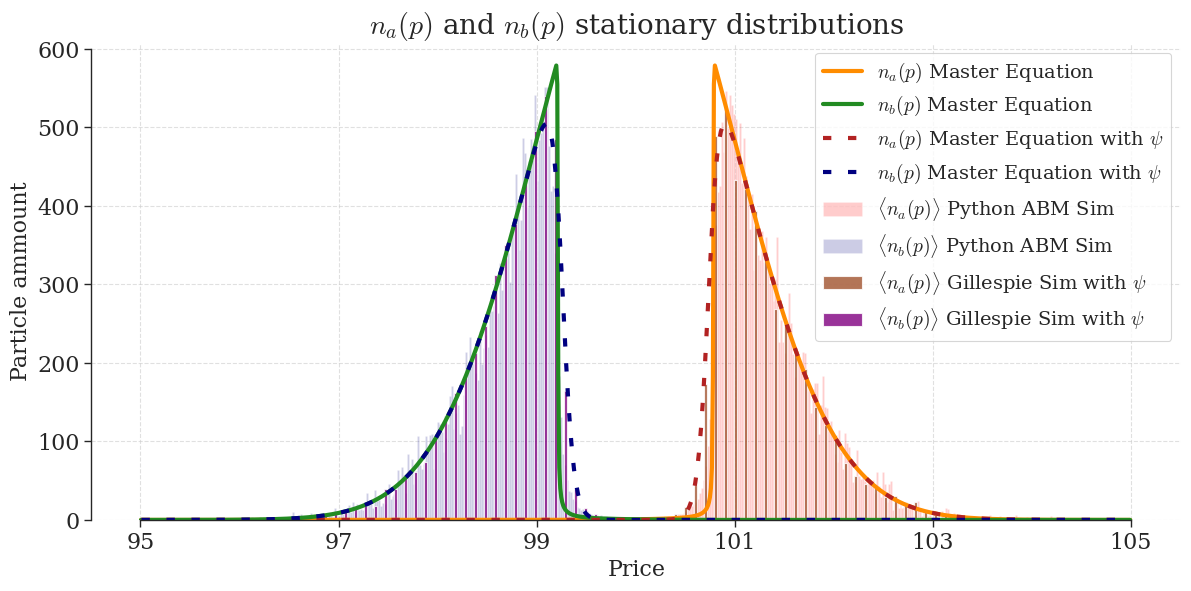

In [ ]:
# Set style
sns.set(style="ticks", context="paper")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.figure(figsize=(10, 6))

# Master equation solutions
plt.plot(sol.t, N_a_total / dp_int_con_beta, label=r'$N_a(t)$ Master Equation', color='black', linestyle='-', linewidth=3)
plt.plot(sol.t, N_b_total / dp_int_con_beta, label=r'$N_b(t)$ Master Equation', color='darkorange', linestyle=(0, (2, 4)), linewidth=3)

# Master equation with psi
plt.plot(times_integral_con_beta, N_a_integral_con_beta / dp_int_con_beta, 
         label=r'$N_a(t)$ Master Equation with $\psi$', color='gold', linestyle='-', linewidth=3)
plt.plot(times_integral_con_beta, N_b_integral_con_beta / dp_int_con_beta,
         label=r'$N_b(t)$ Master Equation with $\psi$', color='forestgreen', linestyle=(0, (2, 4)), linewidth=3)

# Simulation
plt.plot(times_sim, n_a_sim / dp_sim, label=r'$\langle N_a(t) \rangle$ Python ABM Sim', color='firebrick', alpha=0.8)
plt.fill_between(times_sim, lower_bound_n_a_sim/dp_sim, upper_bound_n_a_sim/dp_sim,
                 color='firebrick', alpha=0.1)

plt.plot(times_sim, n_b_sim / dp_sim, label=r'$\langle N_b(t) \rangle$ Python ABM Sim', color='navy', alpha=0.8)
plt.fill_between(times_sim, lower_bound_n_b_sim/dp_sim, upper_bound_n_b_sim/dp_sim,
                 color='navy', alpha=0.1)

# Gillespie with psi
plt.plot(times, n_a_gillespie / dp_sim, label=r'$\langle N_a(t) \rangle$ Gillespie Sim with $\psi$', color='sienna', alpha=0.8)
plt.fill_between(times, lower_bound_mean_series_gillespie_a/dp_sim, upper_bound_mean_series_gillespie_a/dp_sim,
                 color='sienna', alpha=0.1)

plt.plot(times, n_b_gillespie / dp_sim, label=r'$\langle N_b(t) \rangle$ Gillespie Sim with $\psi$', color='purple', alpha=0.8)
plt.fill_between(times, lower_bound_mean_series_gillespie_b/dp_sim, upper_bound_mean_series_gillespie_b/dp_sim,
                 color='purple', alpha=0.1)

plt.title('Particle totals over time', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.xticks(np.arange(0, 1501, step=300))
plt.ylabel('Particle total', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, fancybox=True)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Conexion/Sim vs Int vs Gillespie LOB dinamicas ingles.pdf", format='png', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(12, 6))

# Master equation
plt.plot(midpoints_ec_maest, n_a_last, label=r'$n_a(p)$ Master Equation', color='darkorange', linewidth=3)
plt.plot(midpoints_ec_maest, n_b_last, label=r'$n_b(p)$ Master Equation', color='forestgreen', linewidth=3)

# Master equation with psi
plt.plot(midpoints_int_con_beta, n_a_est_integral_con_beta, 
         label=r'$n_a(p)$ Master Equation with $\psi$', color='firebrick', linestyle=(0, (2, 4)), linewidth=3)
plt.plot(midpoints_int_con_beta, n_b_est_integral_con_beta, 
         label=r'$n_b(p)$ Master Equation with $\psi$', color='navy', linestyle=(0, (2, 4)), linewidth=3)

# Simulation bars
plt.bar(xvalues, n_a_est_sim, dp_sim * 1, align="edge", alpha=0.2, 
        label=r'$\langle n_a(p) \rangle$ Python ABM Sim', color='red')
plt.bar(xvalues, n_b_est_sim, dp_sim * 1, align="edge", alpha=0.2, 
        label=r'$\langle n_b(p) \rangle$ Python ABM Sim', color='navy')

# Gillespie with psi
plt.bar(midpoints_gillespie, n_A_estacionario, dp_gillespie * 0.3, align="center", alpha=0.8,
        label=r'$\langle n_a(p) \rangle$ Gillespie Sim with $\psi$', color='sienna')
plt.bar(midpoints_gillespie, n_B_estacionario, dp_gillespie * 0.3, align="center", alpha=0.8,
        label=r'$\langle n_b(p) \rangle$ Gillespie Sim with $\psi$', color='purple')

plt.title(r'$n_a(p)$ and $n_b(p)$ stationary distributions', fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.xticks(np.arange(95, 106, step=2))
plt.ylabel('Particle ammount', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, fancybox=True)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Conexion/Sim vs Int vs Gillespie LOB estaticas.png", format='png', dpi=300, bbox_inches='tight')
plt.show()